<a href="https://colab.research.google.com/github/Suaif/Video_descriptor/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0. Import of our own module.

Throughout the project we have found that many of the functions occupy a large part of the project, making the code invisible and disorganizing it in some way..Therefore, we have created a separate document where all the functions that we will use will be, we will import this document as a new module, this way we will have access to these functions without them appearing explicitly in the main document.


`*Import OurOwnFunctions.ipynb with all the functions.*`

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!git clone https://github.com/Suaif/Video_descriptor

Cloning into 'Video_descriptor'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [4]:
%cd '/content/Video_descriptor/'

/content/Video_descriptor


In [2]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=72b13135d2e3ef312b57077ea0c6e98412c1df33915ea43730c509aae3982d1c
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
import import_ipynb
import OurOwnFunctions

importing Jupyter notebook from OurOwnFunctions.ipynb


Using TensorFlow backend.


# Step 1. Cleaning and generating our dataset


After some researh we decided to use the MSVD  Dataset, it is made of 1970 YouYube videos each one with different descriptions in different languages.

*  [`MSVD Dataset`](http://www.cs.utexas.edu/users/ml/clamp/videoDescription/)


The original dataset contained descriptions in several languages, we are interested only in the descriptions made in English. So, in the following code cells we will filter the dataset, saving only and exclusively the data in English.


---


**Problems found:**

*  The dataset has different descriptions in the same language for the same video, we decided to use the first English description for each video. Maybe in the future different descriptions could be used for the same video.
*  The dataset contains video names that do not match some of the video names we have. Therefore, we've removed those descriptions whose videos we didn't have.
* Once filtered we realized that the internal 'index' of the dataSet was skipped, we needed to reset the index. 


---




In [8]:
import pandas as pd
import numpy as np

In [9]:
# --- Cleaning dataset.
#   * Select only the English language rows.
#   * Delete the following columns: [WorkerID, Language, Source]
#   * Remove duplicated rows for the same [VideoId]
#   * Create new column [VideoName] with following format: [VideoId_Start_End]

csv_path = "/content/Video_descriptor/video_corpus.csv"
data = pd.read_csv(csv_path)

dataSet = data[data['Language'] == 'English']
dataSet = dataSet.drop(['WorkerID', 'Language', 'Source'], axis=1)
dataSet = dataSet.drop_duplicates(['VideoID'])

dataSet['VideoName'] = dataSet[['VideoID','Start','End']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
dataSet.head()

,VideoID,Start,End,AnnotationTime,Description,VideoName
18,mv89psg6zh4,33,46,66,A bird in a sink keeps getting under the runni...,mv89psg6zh4_33_46
56,ZbzDGXEwtGc,6,15,24,a plane flying in the sky,ZbzDGXEwtGc_6_15
125,jbzaMtPYtl8,48,58,203,Two men are rolling huge tires sideways down a...,jbzaMtPYtl8_48_58
176,g36ho6UrBz0,5,20,28,a man playing a guitar outside his house,g36ho6UrBz0_5_20
251,04Gt01vatkk,248,265,33,A woman cuts an oion.,04Gt01vatkk_248_265


In [ ]:
import os

# -- These filepaths will be used later.
#     * Ipath: Filepath where we have all the videos.
#     * Opath: Filepath where we will save the frames that will train the model.

Ipath = '/content/drive/My Drive/vid/'
Opath = '/content/drive/My Drive/out/'


In [ ]:
# --- Cleaning Dataset of non existing videos.
#   * We check that the route of the video exist, generating a list of those that do not.
#   * We delete the rows of non existing videos.
#   * We clean the Dataset of unnecessary columns [VideoID, Start, End, AnnotationTime]
#   * We save the new clean Dataset.


# -- Get the name of the non existing videos.
name_videosNOTexisting = [ nameV for nameV in dataSet['VideoName'] 
                             if not os.path.exists(Ipath + nameV + '.avi') ]

# -- Remove rows of videos that do not exist.
for videoName in name_videosNOTexisting:
  dataSet.drop(dataSet[dataSet.VideoName == videoName].index , inplace=True)

# -- Get the new dataset
newcorpus = dataSet.drop(['VideoID', 'Start', 'End', 'AnnotationTime'], axis=1)
newcorpus.reset_index(inplace=True, drop=True)
newcorpus.head()

# -- Save the new dataset
newcorpus.to_csv('../newcorpus.csv', index=False)
newcorpus.head()

,Description,VideoName
0,A bird in a sink keeps getting under the runni...,mv89psg6zh4_33_46
1,a plane flying in the sky,ZbzDGXEwtGc_6_15
2,Two men are rolling huge tires sideways down a...,jbzaMtPYtl8_48_58
3,a man playing a guitar outside his house,g36ho6UrBz0_5_20
4,A woman cuts an oion.,04Gt01vatkk_248_265


# Step 2. Model creation 

This will be the structure of our model:

* First we'll analyze the sequence of video frames using VGG16 Model and a LSTM layer. This will produce two internal states vectors

* This vectors will be given to the LSTM encoder along with the video description after being processed by the Embedding layer. 

* The ouput description will be one timestep ahead of the input description, this is because we want the model to predict next word.

* The predicted word will be given in One-Hot encoding so in the last Dense layer we'll need as many neurons as words in our vocabulary.



  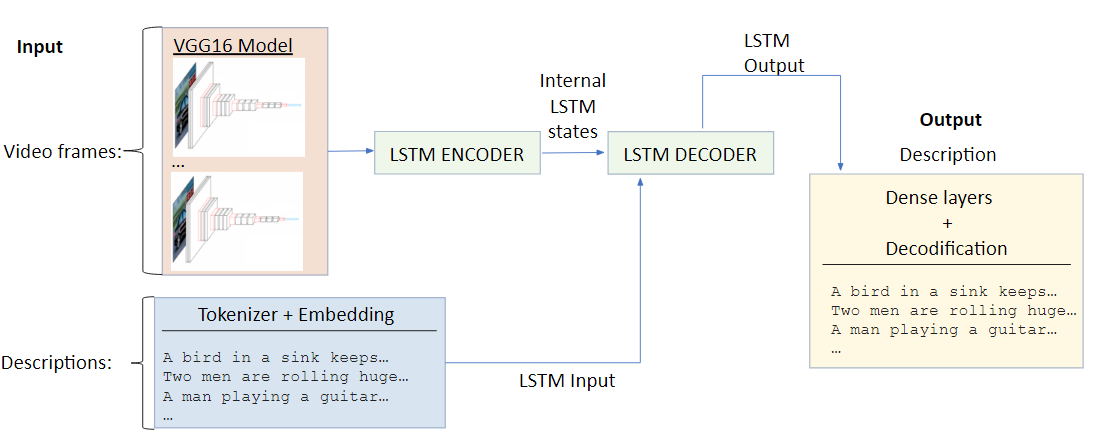

## VGG Model

To use a pre-trained model like VGG16 will help us to better analyze and process our frames. Also the main model will learn faster.

In [11]:
from tensorflow.keras.applications import vgg16

def create_vgg16():  
  model = vgg16.VGG16(include_top=True, 
                      weights="imagenet", 
                      input_tensor=None, 
                      input_shape=None, 
                      pooling=None, 
                      classes=1000)
                      #classifier_activation="softmax")
  return model

vgg16_model = create_vgg16() 

553467904/553467096 [==============================] - 5s 0us/step


## Tokenizer creation

In order to work better with the words we'll tokenize our descriptions.

Besides, we'll add two special characters, one at beggining (BOS-Beginning of secuence) and one at the end (EOS-End of secuence) of each description, so the model can learn to predict the end of a secuence.

In [13]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

data = pd.read_csv("/content/drive/My Drive/proyecto final/newcorpus.csv")
# data = pd.read_csv("../dataSetLIMPIO.csv")

n_descriptions = data.shape[0] #Number of descriptions we have
clean_descriptions = []

for i in range(n_descriptions):

  clean_descriptions.append((str("BOS") + str(" ") + OurOwnFunctions.clean_text(data['Description'][i]) + str(" ") + str("EOS")))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_descriptions)
word_index = tokenizer.word_index

max_sentence_len = max([len(i.split()) for i in clean_descriptions])

print(len(word_index), max_sentence_len)

2059 42


## Embeddings

To get a better word association we will use an embeddings layer

In [14]:
#We will use the pre-trained model of GloVe embeddings, it can be downloaded at: https://nlp.stanford.edu/projects/glove/

import os
import numpy as np

embeddings_index = {}
f = open(os.path.join("/content/drive/My Drive/proyecto final/", 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
#We create the embedding matrix for our vocabulary

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [30]:
#Now we can create our Embeddings layer which we will include in our model

import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding((len(word_index)+1),
                            100,
                            weights=[embedding_matrix],
                            input_length=max_sentence_len, 
                            mask_zero = True,
                            trainable=True)

## Model

Now we can create and compile the main model

In [31]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

# --- Variables

n_frames = 5
height = 224 #(224, 224) because the VGG model is trained for this image size
width = 224 
learn = 0.00001
n_lstm = 64 #Number of units of the LSTM layer, both LSTM layers must have same number because we'll connect the internal states vectors


# --- Hidden vectors LSTM https://www.quora.com/How-is-the-hidden-state-h-different-from-the-memory-c-in-an-LSTM-cell
# --- Model: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

base_model = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer("flatten").output)
base_model.trainable = False #We won't train the VGG model
encoder_inputs = Input((n_frames,224,224,3)) #Input size: secuence of frames
x = TimeDistributed(base_model)(encoder_inputs) #Generar una secuencia temporal en la LSTM a partir del modelo VGG19
lstm_out, lstm_h, lstm_c = LSTM(n_lstm, input_shape=(n_frames, 1), activation='tanh', return_state=True)(x)
encoder_states = [lstm_h,lstm_c] 

''' Once the two hidden states (encoder_states) are concatenated in the same varaible, they will be used to 
inject it into the next LSTM layer and thus initialize it '''

decoder_inputs = Input(shape=(max_sentence_len)) #Input size: Maximum number of words in a description

decoder_Embedding = embedding_layer(decoder_inputs)

'''
  LSTM to decode.
    input:            description secuence of the video
    initial_states:   output of the LSTM encoder, it contains the information of the video analysis
'''

decoder_lstm = LSTM(n_lstm, return_sequences=True, return_state=True, activation='tanh')  
decoder_outputs, _, _ = decoder_lstm(decoder_Embedding, initial_state=encoder_states)

dense = Dense(128,activation='relu')(decoder_outputs)
dense = Dense(len(word_index)+1, activation='softmax')(dense)
decoder_outputs = dense

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(lr=learn), loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 5, 224, 224, 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 25088)     14714688    input_8[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      206000      input_9[0][0]                    
____________________________________________________________________________________________

# Step 3. How to pass the data to the model

We'll use generators to not overload the RAM memory

## Install the Video-Generators library.

This library will extract the frames from the videos.

In [19]:
pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=e5cd37c68dcb2eeb3334d3a6112f288653c4268d5f0b308044e31cba9f8e84c9
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


## VideoGenerator

We will create 3 generators, for train, validation and test.

In [32]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator

import pandas as pd
import numpy as np

# Some generator parameters
SIZE = (height, width)
CHANNELS = 3
NBFRAME = n_frames
BS = 1


# We have the videos with description in a folder named videos:

classes=['videos']

glob_pattern='/content/drive/My Drive/proyecto final/{classname}/*.avi'

# Create video frame generator
train = VideoFrameGenerator(
    glob_pattern=glob_pattern,
    classes = classes,
    nb_frames=NBFRAME,
    split_test=.3, 
    split_val=.3,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

valid = train.get_validation_generator()

test = train.get_test_generator()


class videos, validation count: 447, test count: 313, train count: 731
Total data: 1 classes for 731 files for train
Total data: 1 classes for 447 files for validation
Total data: 1 classes for 313 files for test


## Generadores Custom

Video-generators only give us the frames, we need to create new generators in order to give the model the frames and also their descriptions.


The ouput descriptions have to be one timestep ahead so that the model learns to predict the next word. To make the dimensions fit, a 0 is added at the end of each description.

In [21]:
from keras_video.utils import *
from keras.utils import to_categorical


data = pd.read_csv("/content/drive/My Drive/proyecto final/newcorpus.csv").values

#--- Here we get the names of videos used by each generator

train_ids = [os.path.basename(path).split('.')[0] for path in train.files]
validation_ids = [os.path.basename(path).split('.')[0] for path in valid.files]


def train_generador(train_ids, train, data, tokenizer):

  #-- First we need to obtain the descriptions from the given video names
  Y_train = []
  for i in range(len(train_ids)):
    for j in range(n_descriptions):
      if train_ids[i] == data[j, 6]:
        Y_train.append(clean_descriptions[j])

  Y_train = OurOwnFunctions.padding(tokenizer.texts_to_sequences(Y_train), max_sentence_len)
  Y_train = np.asarray(Y_train)
  Y_train = Y_train[None,:]

  i = 0
  train.next()[0]
  while 1:
    train_images = train.next()[0]/255.
    i +=1
    yield [train_images, Y_train[:,i,:max_sentence_len]], to_categorical(Y_train[:,i,1:], num_classes=len(word_index)+1)
    if i == (train.files_count-1):
      i=0


def validation_generador(validation_ids, valid, data, tokenizer):

  Y_validation = []
  for i in range(len(validation_ids)):
    for j in range(n_descriptions):  
      if validation_ids[i] == data[j, 6]:
        Y_validation.append(clean_descriptions[j])

  Y_validation = OurOwnFunctions.padding(tokenizer.texts_to_sequences(Y_validation), max_sentence_len)
  Y_validation = np.asarray(Y_validation)
  Y_validation = Y_validation[None,:]

  i = 0
  valid.next()[0]
  while 1:
    validation_images = valid.next()[0]/255
    i+=1
    yield [validation_images, Y_validation[:,i,:max_sentence_len]],to_categorical(Y_validation[:,i,1:], num_classes=len(word_index)+1)
    if i==(valid.files_count-1):
      i=0

traingen = train_generador(train_ids, train, data, tokenizer)
validgen = validation_generador(validation_ids,valid,data, tokenizer)

# Step 4. Training

In [28]:
#We can save the model each epoch

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Model64/",
    save_weights_only=False,
    monitor='val_loss',
    verbose=0,
    mode='min',
    save_best_only=True)

In [ ]:
'''
For the frames generated by the custom generators to be synchronized with the descriptions, 
it is necessary to declare the generators each time they are used 
'''
train = VideoFrameGenerator(
    glob_pattern=glob_pattern,
    classes = classes,
    nb_frames=NBFRAME,
    split_test=.3, 
    split_val=.3,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

valid = train.get_validation_generator()

train_ids = [os.path.basename(path).split('.')[0] for path in train.files]
validation_ids = [os.path.basename(path).split('.')[0] for path in valid.files]

traingen = train_generador(train_ids, train, data, tokenizer)
validgen = validation_generador(validation_ids,valid,data, tokenizer)


model.fit_generator(generator=traingen, validation_data=validgen, steps_per_epoch=(train.files_count-1), validation_steps=(valid.files_count-1), epochs=150, callbacks=[checkpoint_callback])

## Saving the model

In [ ]:
model_path = "/content/drive/My Drive/.../Model.h5"
model.save(model_path)

# Step 5. Let's predict!

## Loading a model

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import numpy as np

model = tf.keras.models.load_model("/content/drive/My Drive/Copy of Adadelta.h5")

model.summary()

## Encoder y Decoder

To make predictions we will need to create two sub-models from the main one.

**Encoder**

This sub-model gets the internal states vector after encoding the image sequence

In [23]:
encoder_model = Model(model.layers[0].input, [model.layers[4].output[1], model.layers[4].output[2]])
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 224, 224, 3)]  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 25088)          14714688  
_________________________________________________________________
lstm_2 (LSTM)                [(None, 64), (None, 64),  6439168   
Total params: 21,153,856
Trainable params: 6,439,168
Non-trainable params: 14,714,688
_________________________________________________________________


**Decoder**

This sub-model will predict the next word of the one we give as an imput.

As input it'll have the states vector given by the encoder model and a word.

In [24]:
decoder_states_inputs =  [Input(shape=(n_lstm,)), Input(shape=(n_lstm,))]

decoder_outputs, state_h, state_c = model.layers[5](model.layers[3](model.input[1]), initial_state= decoder_states_inputs)

dense = model.layers[6](decoder_outputs)
decoder_outputs = model.layers[7](dense)

decoder_model = Model([model.layers[1].input] + decoder_states_inputs, 
                  [decoder_outputs] + [state_h, state_c])
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 100)      206000      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 64)]         0                                            
____________________________________________________________________________________________

## Predictions

In [25]:
#--- This new generator will give us a sequence of frames and their description

def test_generador(test_ids, test, data, tokenizer):

  Y_test = []
  for i in range(len(test_ids)):
    for j in range(n_descriptions):  
      if test_ids[i] == data[j, 6]:
        Y_test.append(clean_descriptions[j])

  i = 0
  test.next()[0]
  while 1:
    test_images = test.next()[0]/255
    i+=1
    yield test_images, Y_test[i]
    if i==(test.files_count-1):
      i=0

data = pd.read_csv("/content/drive/My Drive/proyecto final/newcorpus.csv").values
test = train.get_test_generator()
test_ids = [os.path.basename(path).split('.')[0] for path in test.files]
testgen = test_generador(test_ids, test, data, tokenizer)

Total data: 1 classes for 313 files for test


In [ ]:
n = next(testgen)
imgs = n[0]
description = n[1]

secuence = OurOwnFunctions.decode_sequence(imgs, encoder_model, decoder_model, max_sentence_len)
p = OurOwnFunctions.int2str(secuence, tokenizer)

print("----------")
print("Original description: ")
print(n[1])
print("Model description: ")
print(p)

fig, axs = plt.subplots(1, n_frames, figsize=(10,5))

for j in range(n_frames):
  axs[j].imshow(imgs[0,j]*255)
  axs[j].axis('off')